In [1]:
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
from torchmetrics import Metric
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
from PIL import Image
import time
# from tqdm import tqdm

## Data Class Count

In [2]:
# determine number of image in each class

image_dir = 'data/train'

class_count = {}
for label_folder in os.listdir(image_dir):
    if label_folder not in class_count:
        class_count[label_folder] = 0
    data_folder = os.path.join(image_dir, label_folder)
    for image_file in os.listdir(data_folder):
        class_count[label_folder] += 1

print(class_count)

{'1': 2257, '4': 2257, '2': 2404, '5': 2362, '0': 2175, '3': 2498}


## Define Transform

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.43, 0.45, 0.45], std=[0.229, 0.224, 0.225])
    ]
)

## Create Train, Valid Dataset

In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(int(label), dtype=torch.long)
        return image, label

In [5]:
def read_images_paths(image_dir):
    data_images = []
    for label_folder in os.listdir(image_dir):
        data_folder = os.path.join(image_dir, label_folder)
        for image_file in os.listdir(data_folder):
            data_images.append((os.path.join(data_folder, image_file), label_folder))
    return data_images

In [6]:
image_paths = read_images_paths('data/train')

In [7]:
np.random.seed(20)
np.random.shuffle(image_paths)

In [9]:
image_paths[:10]

[('data/train/1/17823.jpg', '1'),
 ('data/train/5/16832.jpg', '5'),
 ('data/train/4/6918.jpg', '4'),
 ('data/train/3/6512.jpg', '3'),
 ('data/train/1/5818.jpg', '1'),
 ('data/train/2/2184.jpg', '2'),
 ('data/train/2/10903.jpg', '2'),
 ('data/train/5/5833.jpg', '5'),
 ('data/train/0/7250.jpg', '0'),
 ('data/train/3/18740.jpg', '3')]

In [10]:
#split train valid from train paths (80,20)
train_val_split = 0.8
train_image_paths, valid_image_paths = image_paths[:int(train_val_split*len(image_paths))], image_paths[int(train_val_split*len(image_paths)):] 

In [11]:
train_dataset = ImageDataset(train_image_paths, transform=transform)
valid_dataset = ImageDataset(valid_image_paths, transform=transform)

In [12]:
# sample some data to compute image mean and std
sample_loader = DataLoader(train_dataset, batch_size=3000, shuffle=True)

for batch, labs in sample_loader:
    train_mean = np.mean(batch.numpy(), axis=(0, 2, 3))
    train_std = np.std(batch.numpy(), axis=(0, 2, 3))
    break

print("train_mean:",train_mean)
print("train_std:",train_std)

train_mean: [0.00612817 0.04007731 0.0201071 ]
train_std: [1.1214328 1.1419685 1.2822547]



## Visualize Dataset Transform

In [11]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img=False):

    dataset = copy.deepcopy(dataset)
    dataset.transform = transforms.Compose([t for t in dataset.transform.transforms \
                                            if not isinstance(t, (transforms.Normalize, transforms.ToTensor))])
    rows = samples // cols

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        lab = int(lab)
        ax.ravel()[i].set_title(lab)
    plt.tight_layout(pad=1)
    plt.show()

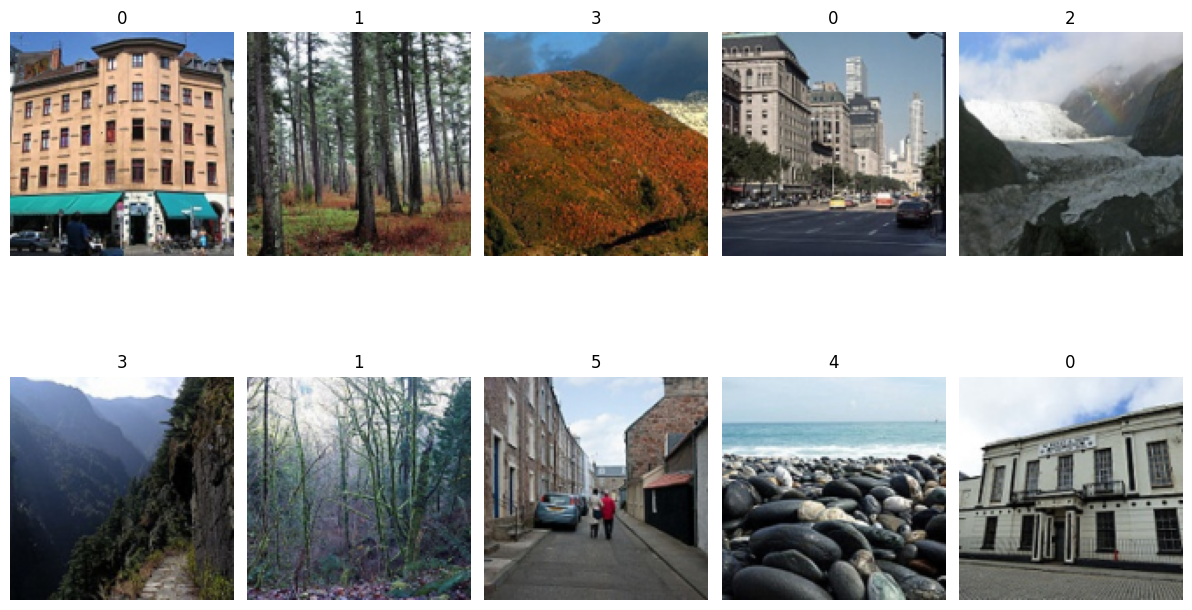

In [12]:
visualize_augmentations(train_dataset, random_img=True)

## Train

In [12]:
# define params
params = {
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 8,
    "n_epochs": 30,
    "in_channels": 3, 
    "num_classes": 6,
    "gradient_accumulation_steps":1,
    "adam_epsilon":1e-6,
    "weight_decay":0
}

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
from transformers import EfficientNetConfig, EfficientNetForImageClassification

# Initializing a EfficientNet by custom configuration
model_config = EfficientNetConfig.from_json_file('model_config.json')
model = EfficientNetForImageClassification(model_config)
model = model.to(device)

In [15]:
model

EfficientNetForImageClassification(
  (efficientnet): EfficientNetModel(
    (embeddings): EfficientNetEmbeddings(
      (padding): ZeroPad2d((0, 1, 0, 1))
      (convolution): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=valid, bias=False)
      (batchnorm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (activation): SiLUActivation()
    )
    (encoder): EfficientNetEncoder(
      (blocks): ModuleList(
        (0): EfficientNetBlock(
          (depthwise_conv): EfficientNetDepthwiseLayer(
            (depthwise_conv_pad): ZeroPad2d((0, 1, 0, 1))
            (depthwise_conv): EfficientNetDepthwiseConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64, bias=False)
            (depthwise_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
            (depthwise_act): SiLUActivation()
          )
          (squeeze_excite): EfficientNetSqueezeExciteLayer(
            (squeeze): Adap

In [17]:
# create dataset loader

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers = params['num_workers'], pin_memory = True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=False, num_workers = params['num_workers'], pin_memory = True
)

In [18]:
# define metric
class Accuracy(Metric):
    def __init__(self, name, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.name = name

    def update(self, preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor = None):
        # update metric states
        if len(preds.shape) > len(target.shape):
            preds = torch.argmax(preds, -1)

        compare = (preds == target)
        # if mask is not None: compare = compare * mask
        self.correct += torch.sum(compare).int().cpu()

        # if mask is not None: target = target * mask
        target = torch.sum(target > -1)
        self.total += torch.sum(target).cpu()

    def compute(self):
        # compute final result
        return self.correct.float() / self.total


class Average(Metric):
    def __init__(self, name, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("sum", default=torch.tensor(0.0, dtype=torch.float32), dist_reduce_fx="sum")
        self.add_state("count", default=torch.tensor(0), dist_reduce_fx="sum")
        self.name = name

    def update(self, loss):
        # update metric states
        if isinstance(loss, torch.Tensor):
            loss = loss.cpu()
        self.sum += loss
        self.count += 1

    def compute(self):
        # compute final result
        return self.sum.float() / self.count

In [19]:
eval_metric = [Accuracy(name='eval_accuracy'), Average(name='eval_loss')]
train_metric = [Accuracy(name='train_accuracy'), Average(name='train_loss')]

In [19]:
# save checkpoints
model_dir = 'efficientNet_ckpt'

def save_check_points(model, optimizer, path, loss=None):
#     if 'step' in path:
#         save_key = 'step'
#     else:
#         save_key = 'epoch'
    value = int(path.split('_')[2][:-5])
    save_path = model_dir + '/' + path

    save_object = {
        'epoch': value,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}
    if loss:
        save_object['loss'] = loss
    torch.save(save_object, save_path)

In [21]:
def get_metrics(msg, metrics):
    training_status = msg
    for metric in metrics:
        metric_value = metric.compute()
        training_status += '  %s = %f' % (metric.name, metric_value)
    return training_status

In [22]:
def train_one_epoch(model, params, loss_fn, optimizer, train_loader):
    num_train_step = 0
    model.train() 
    gradient_accumulation_steps = params['gradient_accumulation_steps']
    begin_time = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        logits = output['logits']
        
        loss = loss_fn(logits.view(-1, model.num_labels), labels.view(-1))
        
        #update train_metric
        train_metric[0](logits.cpu(), labels.cpu())
        train_metric[1](loss.cpu())

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()

        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
#             if scheduler:
#                 scheduler.step()
            optimizer.zero_grad()

        # print(f'time cost {time.time() - begin_time} seconds')
        num_train_step += 1

In [23]:
def perform_eval(model, loss_fn, eval_loader):

    model.eval()
    for batch_idx, (imgs, labels) in enumerate(eval_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        logits = output['logits']
        
        loss = loss_fn(logits.view(-1, model.num_labels), labels.view(-1))
        
        eval_metric[0](logits.cpu(), labels.cpu())
        eval_metric[1](loss.cpu())
    return eval_metric[1].compute()

In [24]:
params

{'lr': 0.001,
 'batch_size': 64,
 'num_workers': 8,
 'n_epochs': 30,
 'in_channels': 3,
 'num_classes': 6,
 'gradient_accumulation_steps': 1,
 'adam_epsilon': 1e-06,
 'weight_decay': 0}

In [25]:
'number of steps per epoch is', int(len(train_loader.dataset) / params['batch_size'])

('number of steps per epoch is', 174)

In [26]:
# start training

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], eps=params['adam_epsilon'], weight_decay=params['weight_decay'])
loss_fn = nn.CrossEntropyLoss()
n_epochs = params['n_epochs']

# use for early stop
patience = 3
counter = 0
min_loss = None

for epoch in range(n_epochs):
    
    print(f'start train epoch : {epoch+1}/{n_epochs}')
    train_one_epoch(model, params, loss_fn, optimizer, train_loader)
    
    train_report = get_metrics("finish train epoch", train_metric)
    print(train_report)
    
    print("****evaluation****")
    eval_loss = perform_eval(model, loss_fn, valid_loader)
    eval_report = get_metrics("", eval_metric)
    print(eval_report)

    # early stop
    if min_loss is None:
        min_loss = eval_loss
        save_check_points(model, optimizer, f'ctl_epoch_{epoch+1}.ckpt', eval_loss)
    elif eval_loss > min_loss:
        counter += 1
        print(f"""found loss {eval_loss} bigger than smallest loss {min_loss}
               EarlyStopping counter: {counter} out of {patience}""")
        if counter >= patience:
#             load_latest_checkpoint()
            break
    else:
        min_loss = eval_loss
        save_check_points(model, optimizer, f'ctl_epoch_{epoch+1}.ckpt', eval_loss)
        counter = 0

    #reset metric
    for metric in train_metric + eval_metric:
        metric.reset()

start train epoch : 1/30
finish train epoch  train_accuracy = 0.615571  train_loss = 0.969956
****evaluation****
  eval_accuracy = 0.687567  eval_loss = 0.904172
start train epoch : 2/30
finish train epoch  train_accuracy = 0.710267  train_loss = 0.780071
****evaluation****
  eval_accuracy = 0.740953  eval_loss = 0.759594
start train epoch : 3/30
finish train epoch  train_accuracy = 0.748163  train_loss = 0.689167
****evaluation****
  eval_accuracy = 0.792189  eval_loss = 0.570962
start train epoch : 4/30
finish train epoch  train_accuracy = 0.781401  train_loss = 0.592363
****evaluation****
  eval_accuracy = 0.807954  eval_loss = 0.515730
start train epoch : 5/30
finish train epoch  train_accuracy = 0.802007  train_loss = 0.545245
****evaluation****
  eval_accuracy = 0.826227  eval_loss = 0.491248
start train epoch : 6/30
finish train epoch  train_accuracy = 0.815087  train_loss = 0.504263
****evaluation****
  eval_accuracy = 0.828735  eval_loss = 0.460669
start train epoch : 7/30
fin

## run prediction on sample dataset

In [16]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):

        self.images = []
        for image_file in os.listdir(img_dir):
            self.images.append(os.path.join(img_dir, image_file))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        return image

In [17]:
def load_latest_checkpoint(model_dir, model):
    maxtime = None
    lastest_file = None
    for file_name in os.listdir(model_dir):
        if file_name.endswith('ckpt'):
            file_name = os.path.join(model_dir, file_name)
            file_time = os.path.getctime(file_name)
            if maxtime is None:
                maxtime = file_time
                lastest_file = file_name
            elif file_time > maxtime:
                maxtime = file_time
                lastest_file = file_name
    print(f"found latest checkpoint {lastest_file.split('/')[-1]}")
    checkpoint = torch.load(lastest_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    print('load checkpoint completed')
    return model

In [22]:
model = load_latest_checkpoint(model_dir, model)

found latest checkpoint ctl_epoch_18.ckpt
load checkpoint completed


In [23]:
test_dataset = TestDataset('data/sample_test/', transform)

In [24]:
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers = params['num_workers'], pin_memory = True
)

In [25]:
for img in test_loader:
    img = img.to(device)
    logits = model(img).logits
    prediction = torch.argmax(logits, -1)

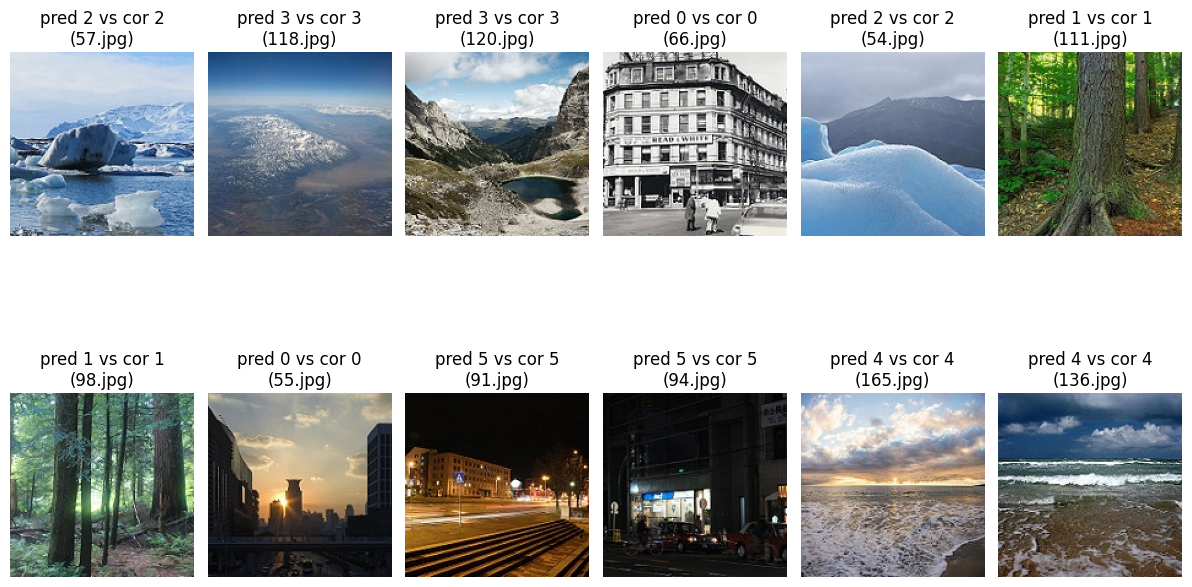

In [26]:
# visulization on sample_data
rows = 2
cols = 6
samples = len(test_dataset)
rows = samples // cols

correct_label = [2,3,3,0,2,1,1,0,5,5,4,4]
figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
for i in range(samples):
    image_path = test_dataset.images[i]
    image = Image.open(image_path)
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_axis_off()
    lab = int(prediction[i])
    title = f"pred {str(lab)} vs cor {str(correct_label[i])}\n({image_path.split('/')[-1]})"
    ax.ravel()[i].set_title(title)
plt.tight_layout(pad=1)
plt.show()

#looks good, got all of them right